# Simulation study

In order to test whether hierarchical approaches are suited to recover parameters if they are applied to models that are an adequate description of the reality, we take the following steps to create artificial data

1. Simulate data from a deterministic process with a structured source of uncertainty
2. Add white noise to the data
3. Mask random fractions of the data and recover parameters
4. Mask systematic fractions of the data according to sparsity assumptions of experimental design and recover parameters
5. Compare the results

In [1]:
import os
from matplotlib import pyplot as plt
from scipy.stats import lognorm, norm, multinomial
import numpy as np
from hierarchical_molecular_tktd.sim import NomixHierarchicalSimulation
from pymob import Config

if os.path.basename(os.getcwd()) != "hierarchical_molecular_tktd":
    os.chdir("..")

We use the hierarchical model that has been identified as the best compromise between degrees of freedom and constraints to converge on the 

## Simulating noise in the experimental structure

In order to make our case, we assume that the nominal concentrations are the true concentrations.

We add a structured source of uncertainty on the observations, assuming that the stock solutions of the treatment solutions used in the experiment are deviating systematically (due to weigh in issues, but within the experiments there is no error)

We see that a lognormal distribution with a scale parameter of 1.0 and a log-standard deviation of 0.5 has low probability of deviating from nominal concentrations of a factor of 10 or more in either direction. The median of the distribution lies at 1.0, implying that we expect to see most of the experiments correctly executed at the nominal concentrations, with some outliers above and below. 

In order to structure the between-experiment-variation over all observations, the deviation factors are mapped to the ID level by indexing each value multiple times for the respective occurences of the experiment_id in the observation matrix

In [23]:
true_parameters = dict(
    k_i_substance=np.array([4.9, 0.38, 0.36]),
    k_m_substance=np.array([3.8, 0.19, 0.084]),
    z_ci_substance=np.array([1.2, 1.0, 1.2]),
    ci_max_substance=np.array([1757.0,168.1,6364.8]),
    h_b=0.0,
    k_p=0.008,
    kk=0.079,
    r_rd=0.23,
    r_rt=2.3,
    v_rt=3.7,
    z=1.5,
)

/home/flo-schu/projects/pymob/pymob/sim/parameters.py:126: UserWarning: The distribution 'deterministic' is not part of the scipy distributions implemented in pymob. This can lead to inconsistent behavior. It is recommended to use the scipy distribution protocol where possible. https://docs.scipy.org/doc/scipy/reference/stats.html It may also be possible that your distribution has not yet been introduced into the pymob package 
  warnings.warn(


MinMaxScaler(variable=cint, min=1e-08, max=6582.763087754983)
MinMaxScaler(variable=nrf2, min=0.6215531717356583, max=3.806557074337876)
MinMaxScaler(variable=survival, min=0.0, max=18.0)
Results directory created at '/home/flo-schu/projects/hierarchical_tktd/case_studies/hierarchical_molecular_tktd/results/simulation_study_v3_variability_0.1_overlap_0.5'.
Scenario directory created at '/home/flo-schu/projects/hierarchical_tktd/case_studies/hierarchical_molecular_tktd/scenarios/simulation_study_v3_variability_0.1_overlap_0.5'.
MinMaxScaler(variable=cint, min=0.0, max=10690.029362024803)
MinMaxScaler(variable=nrf2, min=0.6215531717356583, max=13.09490508227517)
MinMaxScaler(variable=survival, min=0.0, max=20.0)


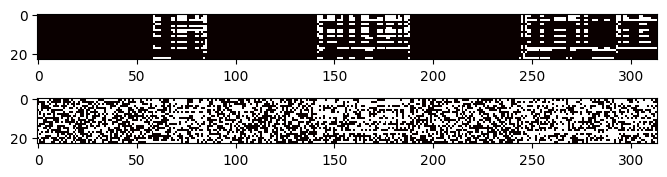

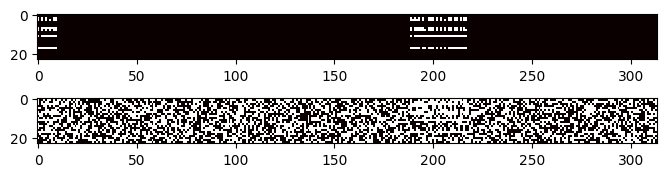

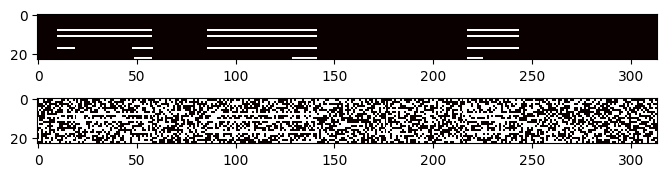

MinMaxScaler(variable=cint, min=0.0, max=10427.805362362513)
MinMaxScaler(variable=nrf2, min=0.6215531717356583, max=12.141295704962001)
MinMaxScaler(variable=survival, min=0.0, max=20.0)


In [43]:
def setup_simulation_study(
    experimental_variability=0.5, 
    within_experiment_endpoint_overlap=0.0
):

    config = Config("scenarios/simulation_study_v2_informed_masked/settings.cfg")
    config.case_study.scenario = "simulation_study_v3_variability_{vari}_overlap_{over}".format(
        vari=experimental_variability,
        over=within_experiment_endpoint_overlap,
    )
    sim = NomixHierarchicalSimulation(config)
    sim.setup()

    # create random between experiments variation
    ce_nom = sim.observations.cext_nom
    sigma_k = lognorm(scale=1, s=experimental_variability)
    sigma_k_vals = sigma_k.rvs(size=42, random_state=6)
    ce_true = sim.observations.cext_nom * sigma_k_vals[sim.indices["experiment_id"]]

    _theta = true_parameters.copy()
    _theta["k_i"] = _theta["k_i_substance"][sim.indices["substance"]]
    _theta["k_m"] = _theta["k_m_substance"][sim.indices["substance"]]
    _theta["z_ci"] = _theta["z_ci_substance"][sim.indices["substance"]]
    _theta["ci_max"] = _theta["ci_max_substance"][sim.indices["substance"]]

    # simulate deterministic data based on true external coencentrations
    e = sim.dispatch(
        y0=sim.validate_model_input(ce_true.to_dataset(name="cext")),
        theta=_theta
    )

    e()

    # store original mask of experiments
    mask_zero_overlap = ~sim.observations.isnull()
    mask_zero_overlap["nzfe"] = mask_zero_overlap.nzfe.isel(time=0)

    # add noise to data
    sim.observations["nzfe"] = sim.observations.nzfe.isel(time=0)
    sim.observations["cext"].values = e.results.cext
    sim.observations["cint"].values = e.results.cint * np.exp(norm(loc=0, scale=0.1).rvs((314,23), random_state=2))
    sim.observations["nrf2"].values = e.results.nrf2 * np.exp(norm(loc=0, scale=0.1).rvs((314,23), random_state=3))
    multinom_surv = (1-e.results.survival).diff(dim="time")
    multinom_surv = np.column_stack([multinom_surv.values, 1-multinom_surv.sum("time")])
    multinom_surv = np.clip(multinom_surv,0.000001,0.99999) 
    incidence = np.array(list(map(lambda x, n: multinomial(p=x/x.sum(), n=n).rvs(), multinom_surv, sim.observations.nzfe.values) )).squeeze()
    sim.observations["lethality"].values = np.column_stack([np.zeros_like(incidence[:,0]), incidence.cumsum(axis=1)[:,:-1]])
    sim.observations = sim.lethality_to_conditional_survival(sim.observations)
    sim.observations["nzfe"] = sim.observations.nzfe.isel(time=0)


    # mask data    
    rng = np.random.default_rng(1)
    for endpoint in ["cint", "nrf2", "survival"]:
        mask_endpoint = mask_zero_overlap[endpoint].copy()
        n_masked_endpoint = int((~mask_zero_overlap[endpoint]).sum())
        n_frac_unmasked_endpoint = int(n_masked_endpoint * within_experiment_endpoint_overlap)
        unmask_indices_endpoint = np.full(n_masked_endpoint, False)
        unmask_indices_endpoint[:n_frac_unmasked_endpoint] = True
        rng.shuffle(unmask_indices_endpoint)
        idx_0, idx_1 =  np.where(~mask_endpoint)
        idx_0[unmask_indices_endpoint]
        idx_1[unmask_indices_endpoint]

        mask_endpoint.values[idx_0[unmask_indices_endpoint], idx_1[unmask_indices_endpoint]] = True

        fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,2))
        ax1.imshow(mask_zero_overlap[endpoint].T, cmap='hot', interpolation='nearest', )
        ax2.imshow(mask_endpoint.T, cmap='hot', interpolation='nearest', )
        plt.show()
        
        sim.observations[endpoint] = sim.observations[endpoint].where(mask_endpoint, np.nan)


    sim.observations = sim.lethality_to_conditional_survival(sim.observations)
    sim.config.save(force=True)
    return sim


## Systematic simulation study

to investigate the influence of endpoint overlap and observation noise on parameter bias, we conduct a systematic simulation study and measure the effect on the cumulative relative deviation from the true parameter values (which we name parameter bias)


In [ ]:
def run_inference(sim, force=False):
    sim.dispatch_constructor()
    sim.set_inferer("numpyro")
    sim.config.inference_numpyro.svi_iterations = 1000
    sim.config.inference_numpyro.svi_learning_rate = 0.005
    sim.config.inference_numpyro.kernel = "map"
    sim.config.simulation.seed=2

    try: 
        sim.inferer.load_results()
        if force:
            raise FileNotFoundError
    except FileNotFoundError:
        sim.inferer.run()
        sim.inferer.store_results()
        sim.report()

    return sim

In [44]:
def compute_bias(sim):
    compare_params = ["k_i_substance", "k_m_substance", "z_ci_substance", "k_p", "kk", "r_rd", "r_rt", "v_rt", "z"]
    estimated = sim.inferer.posterior[true_parameters.keys()].mean(("chain", "draw"))
    relative_bias = np.abs((estimated - true_parameters) / true_parameters)[compare_params]
    absolute_bias = np.abs((estimated - true_parameters))[compare_params]
    return float(relative_bias.sum().to_array().sum()), float(absolute_bias.sum().to_array().sum())


/home/flo-schu/projects/pymob/pymob/sim/parameters.py:126: UserWarning: The distribution 'deterministic' is not part of the scipy distributions implemented in pymob. This can lead to inconsistent behavior. It is recommended to use the scipy distribution protocol where possible. https://docs.scipy.org/doc/scipy/reference/stats.html It may also be possible that your distribution has not yet been introduced into the pymob package 
  warnings.warn(


MinMaxScaler(variable=cint, min=1e-08, max=6582.763087754983)
MinMaxScaler(variable=nrf2, min=0.6215531717356583, max=3.806557074337876)
MinMaxScaler(variable=survival, min=0.0, max=18.0)
Results directory exists at '/home/flo-schu/projects/hierarchical_tktd/case_studies/hierarchical_molecular_tktd/results/simulation_study_v3_variability_0.1_overlap_0.5'.
Scenario directory exists at '/home/flo-schu/projects/hierarchical_tktd/case_studies/hierarchical_molecular_tktd/scenarios/simulation_study_v3_variability_0.1_overlap_0.5'.
MinMaxScaler(variable=cint, min=0.0, max=10690.029362024803)
MinMaxScaler(variable=nrf2, min=0.6215531717356583, max=13.09490508227517)
MinMaxScaler(variable=survival, min=0.0, max=20.0)


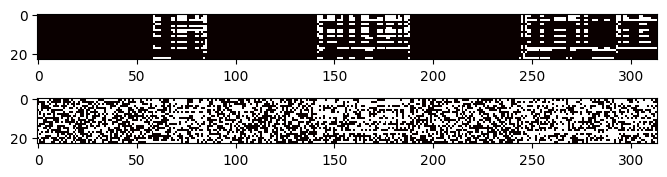

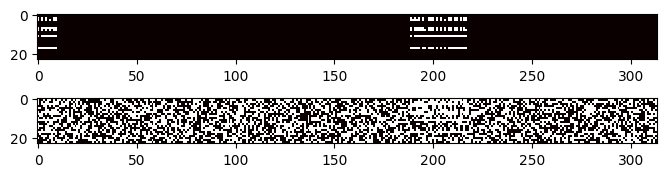

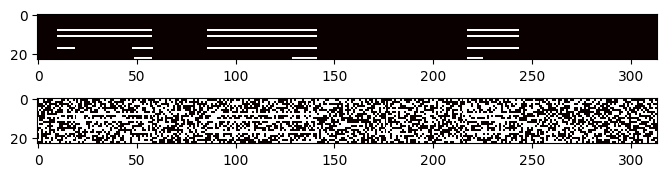

MinMaxScaler(variable=cint, min=0.0, max=10427.805362362513)
MinMaxScaler(variable=nrf2, min=0.6215531717356583, max=12.141295704962001)
MinMaxScaler(variable=survival, min=0.0, max=20.0)
Jax 64 bit mode: False
Absolute tolerance: 1e-05
                     Trace Shapes:         
                      Param Sites:         
                     Sample Sites:         
      error_scale_normal_base dist        |
                             value        |
error_scale_sigma_normal_base dist        |
                             value        |
 sigma_experiment_normal_base dist     42 |
                             value     42 |
    k_i_substance_normal_base dist      3 |
                             value      3 |
   z_ci_substance_normal_base dist      3 |
                             value      3 |
    k_m_substance_normal_base dist      3 |
                             value      3 |
             r_rt_normal_base dist        |
                             value        |
             r_

100%|██████████| 500/500 [00:32<00:00, 15.27it/s, init loss: 140457.8750, avg. loss [476-500]: -7276.0405]
/home/flo-schu/miniconda3/envs/molecular-tktd/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/flo-schu/miniconda3/envs/molecular-tktd/lib/python3.11/site-packages/numpy/core/_methods.py:258: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/flo-schu/miniconda3/envs/molecular-tktd/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/flo-schu/miniconda3/envs/molecular-tktd/lib/python3.11/site-packages/numpy/core/_methods.py:258: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/flo-schu/miniconda3/envs/molecular-tktd/lib/python3.11/site-packages/numpy/core/_methods.py:269: Runtim

                             mean  sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
cext_y0[101_0]              1.920 NaN   1.920    1.920        NaN      NaN   
cext_y0[101_1]              1.920 NaN   1.920    1.920        NaN      NaN   
cext_y0[106_0]              4.234 NaN   4.234    4.234        NaN      NaN   
cext_y0[106_1]              4.234 NaN   4.234    4.234        NaN      NaN   
cext_y0[112_0]              9.616 NaN   9.616    9.616        NaN      NaN   
...                           ...  ..     ...      ...        ...      ...   
z_ci[77_7]                  1.192 NaN   1.192    1.192        NaN      NaN   
z_ci[77_8]                  1.192 NaN   1.192    1.192        NaN      NaN   
z_ci_substance[diuron]      1.176 NaN   1.176    1.176        NaN      NaN   
z_ci_substance[diclofenac]  0.990 NaN   0.990    0.990        NaN      NaN   
z_ci_substance[naproxen]    1.192 NaN   1.192    1.192        NaN      NaN   

                            ess_bulk  ess_tail  r_hat  
cext_y0

/home/flo-schu/miniconda3/envs/molecular-tktd/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/flo-schu/miniconda3/envs/molecular-tktd/lib/python3.11/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/flo-schu/miniconda3/envs/molecular-tktd/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/flo-schu/miniconda3/envs/molecular-tktd/lib/python3.11/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/flo-schu/miniconda3/envs/molecular-tktd/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtyp

PRETTY PLOT: starting...


Posterior predictions: 100%|██████████| 1/1 [00:00<00:00, 13.58it/s]


PRETTY PLOT: make predictions for Diuron in bin (1/5)
PRETTY PLOT: make predictions for Diuron in bin (2/5)
PRETTY PLOT: make predictions for Diuron in bin (3/5)
PRETTY PLOT: make predictions for Diuron in bin (4/5)
PRETTY PLOT: make predictions for Diuron in bin (5/5)
PRETTY PLOT: make predictions for Diclofenac in bin (1/4)
PRETTY PLOT: make predictions for Diclofenac in bin (2/4)
PRETTY PLOT: make predictions for Diclofenac in bin (3/4)
PRETTY PLOT: make predictions for Diclofenac in bin (4/4)
PRETTY PLOT: make predictions for Naproxen in bin (1/6)
PRETTY PLOT: make predictions for Naproxen in bin (2/6)
PRETTY PLOT: make predictions for Naproxen in bin (3/6)
PRETTY PLOT: make predictions for Naproxen in bin (4/6)
PRETTY PLOT: make predictions for Naproxen in bin (5/6)
PRETTY PLOT: make predictions for Naproxen in bin (6/6)


/home/flo-schu/projects/pymob/pymob/inference/numpyro_backend.py:685: UserWarning: Discouraged use of inferer.posterior APIuse inferer.idata.posterior instead.
  warnings.warn(


1.6847532090559016


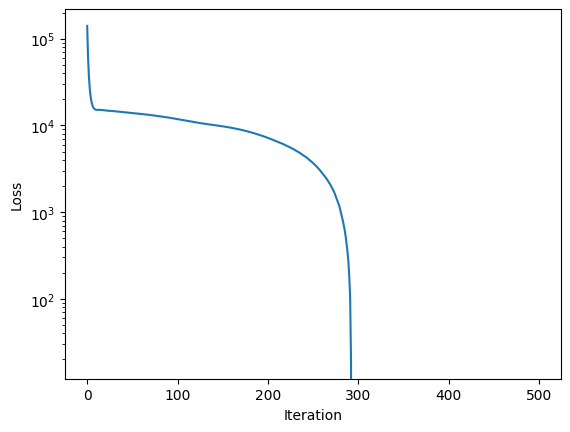

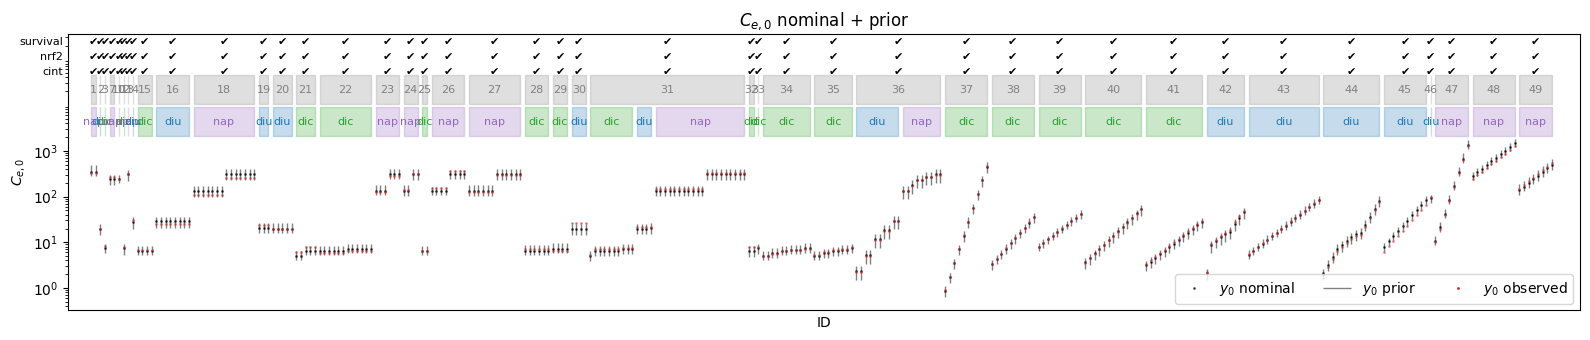

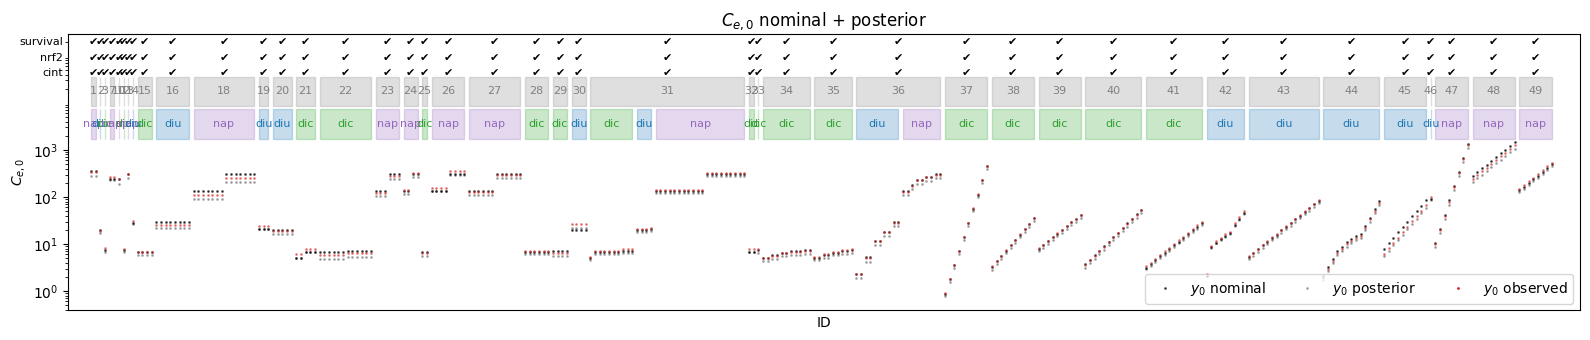

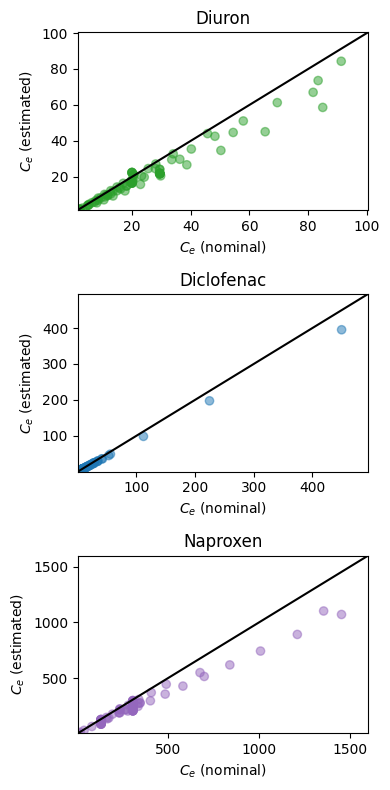

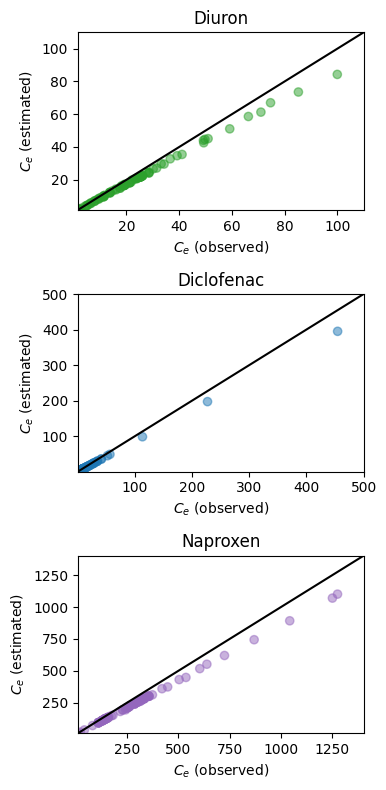

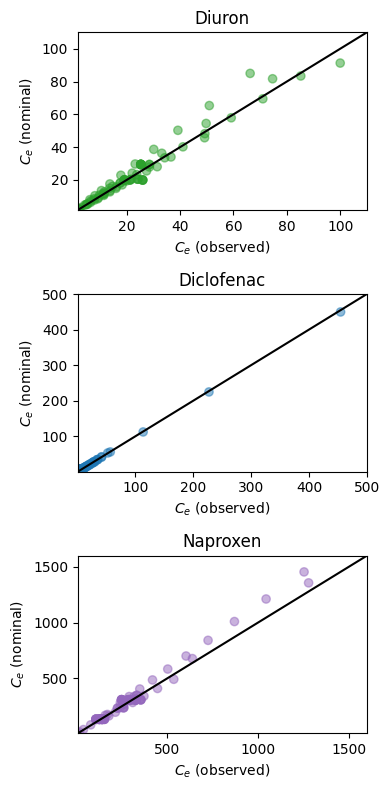

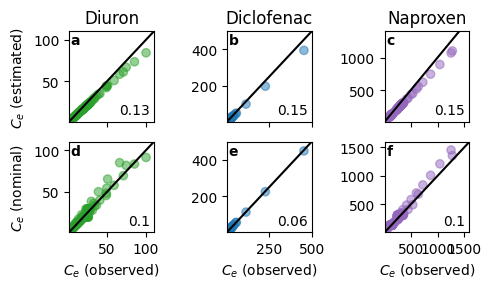

In [45]:
sim = setup_simulation_study(experimental_variability=0.1, within_experiment_endpoint_overlap=0.5)

sim = run_inference(sim)
rel_bias, abs_bias = compute_bias(sim)

print(rel_bias)

/home/flo-schu/projects/pymob/pymob/sim/parameters.py:126: UserWarning: The distribution 'deterministic' is not part of the scipy distributions implemented in pymob. This can lead to inconsistent behavior. It is recommended to use the scipy distribution protocol where possible. https://docs.scipy.org/doc/scipy/reference/stats.html It may also be possible that your distribution has not yet been introduced into the pymob package 
  warnings.warn(


MinMaxScaler(variable=cint, min=1e-08, max=6582.763087754983)
MinMaxScaler(variable=nrf2, min=0.6215531717356583, max=3.806557074337876)
MinMaxScaler(variable=survival, min=0.0, max=18.0)
Results directory exists at '/home/flo-schu/projects/hierarchical_tktd/case_studies/hierarchical_molecular_tktd/results/simulation_study_v3_variability_0.1_overlap_0.5'.
Scenario directory exists at '/home/flo-schu/projects/hierarchical_tktd/case_studies/hierarchical_molecular_tktd/scenarios/simulation_study_v3_variability_0.1_overlap_0.5'.
MinMaxScaler(variable=cint, min=0.0, max=10690.029362024803)
MinMaxScaler(variable=nrf2, min=0.6215531717356583, max=13.09490508227517)
MinMaxScaler(variable=survival, min=0.0, max=20.0)


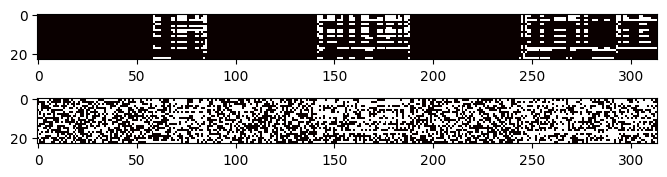

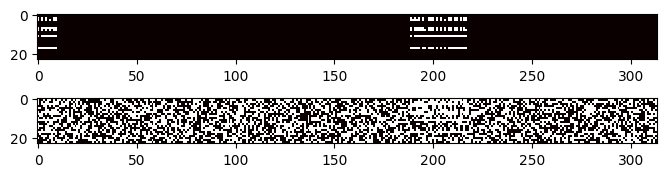

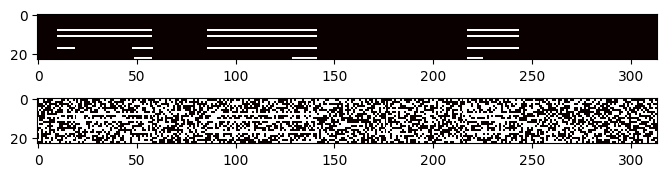

MinMaxScaler(variable=cint, min=0.0, max=10427.805362362513)
MinMaxScaler(variable=nrf2, min=0.6215531717356583, max=12.141295704962001)
MinMaxScaler(variable=survival, min=0.0, max=20.0)
Jax 64 bit mode: False
Absolute tolerance: 1e-05
                     Trace Shapes:         
                      Param Sites:         
                     Sample Sites:         
      error_scale_normal_base dist        |
                             value        |
error_scale_sigma_normal_base dist        |
                             value        |
 sigma_experiment_normal_base dist     42 |
                             value     42 |
    k_i_substance_normal_base dist      3 |
                             value      3 |
   z_ci_substance_normal_base dist      3 |
                             value      3 |
    k_m_substance_normal_base dist      3 |
                             value      3 |
             r_rt_normal_base dist        |
                             value        |
             r_

100%|██████████| 500/500 [00:32<00:00, 15.27it/s, init loss: 140457.8750, avg. loss [476-500]: -7276.0405]
/home/flo-schu/miniconda3/envs/molecular-tktd/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/flo-schu/miniconda3/envs/molecular-tktd/lib/python3.11/site-packages/numpy/core/_methods.py:258: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/flo-schu/miniconda3/envs/molecular-tktd/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/flo-schu/miniconda3/envs/molecular-tktd/lib/python3.11/site-packages/numpy/core/_methods.py:258: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/flo-schu/miniconda3/envs/molecular-tktd/lib/python3.11/site-packages/numpy/core/_methods.py:269: Runtim

                             mean  sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
cext_y0[101_0]              1.920 NaN   1.920    1.920        NaN      NaN   
cext_y0[101_1]              1.920 NaN   1.920    1.920        NaN      NaN   
cext_y0[106_0]              4.234 NaN   4.234    4.234        NaN      NaN   
cext_y0[106_1]              4.234 NaN   4.234    4.234        NaN      NaN   
cext_y0[112_0]              9.616 NaN   9.616    9.616        NaN      NaN   
...                           ...  ..     ...      ...        ...      ...   
z_ci[77_7]                  1.192 NaN   1.192    1.192        NaN      NaN   
z_ci[77_8]                  1.192 NaN   1.192    1.192        NaN      NaN   
z_ci_substance[diuron]      1.176 NaN   1.176    1.176        NaN      NaN   
z_ci_substance[diclofenac]  0.990 NaN   0.990    0.990        NaN      NaN   
z_ci_substance[naproxen]    1.192 NaN   1.192    1.192        NaN      NaN   

                            ess_bulk  ess_tail  r_hat  
cext_y0

/home/flo-schu/miniconda3/envs/molecular-tktd/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/flo-schu/miniconda3/envs/molecular-tktd/lib/python3.11/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/flo-schu/miniconda3/envs/molecular-tktd/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/flo-schu/miniconda3/envs/molecular-tktd/lib/python3.11/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/flo-schu/miniconda3/envs/molecular-tktd/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtyp

PRETTY PLOT: starting...


Posterior predictions: 100%|██████████| 1/1 [00:00<00:00, 13.58it/s]


PRETTY PLOT: make predictions for Diuron in bin (1/5)
PRETTY PLOT: make predictions for Diuron in bin (2/5)
PRETTY PLOT: make predictions for Diuron in bin (3/5)
PRETTY PLOT: make predictions for Diuron in bin (4/5)
PRETTY PLOT: make predictions for Diuron in bin (5/5)
PRETTY PLOT: make predictions for Diclofenac in bin (1/4)
PRETTY PLOT: make predictions for Diclofenac in bin (2/4)
PRETTY PLOT: make predictions for Diclofenac in bin (3/4)
PRETTY PLOT: make predictions for Diclofenac in bin (4/4)
PRETTY PLOT: make predictions for Naproxen in bin (1/6)
PRETTY PLOT: make predictions for Naproxen in bin (2/6)
PRETTY PLOT: make predictions for Naproxen in bin (3/6)
PRETTY PLOT: make predictions for Naproxen in bin (4/6)
PRETTY PLOT: make predictions for Naproxen in bin (5/6)
PRETTY PLOT: make predictions for Naproxen in bin (6/6)


/home/flo-schu/projects/pymob/pymob/inference/numpyro_backend.py:685: UserWarning: Discouraged use of inferer.posterior APIuse inferer.idata.posterior instead.
  warnings.warn(


1.6847532090559016


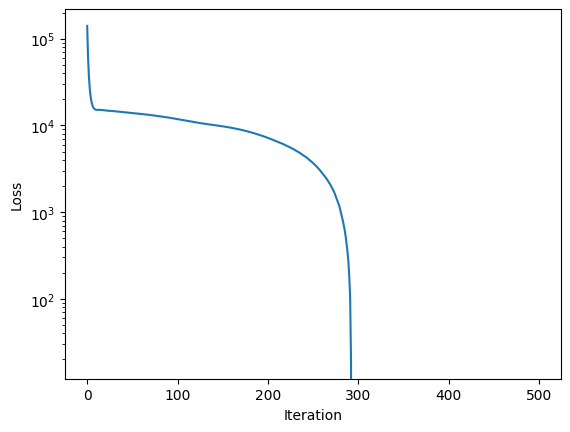

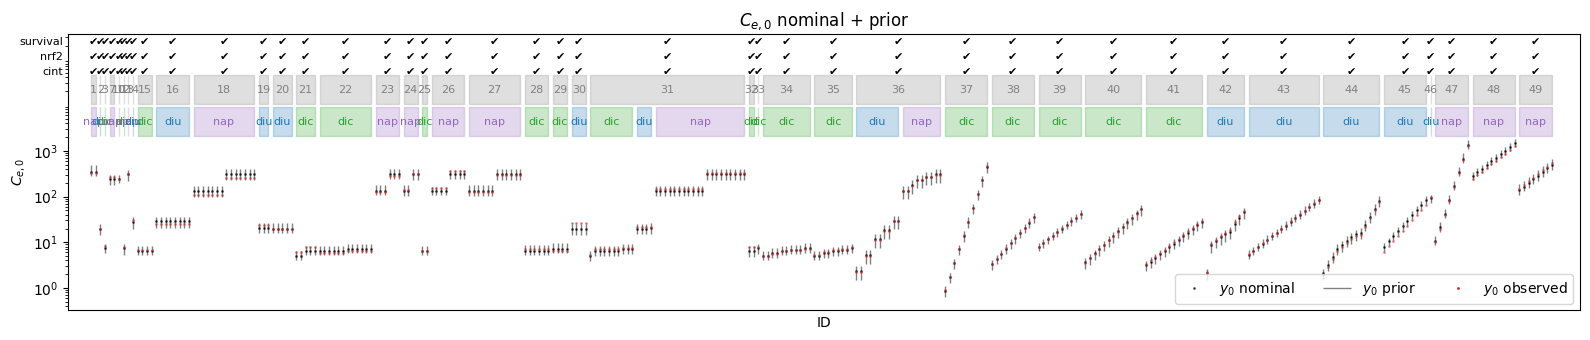

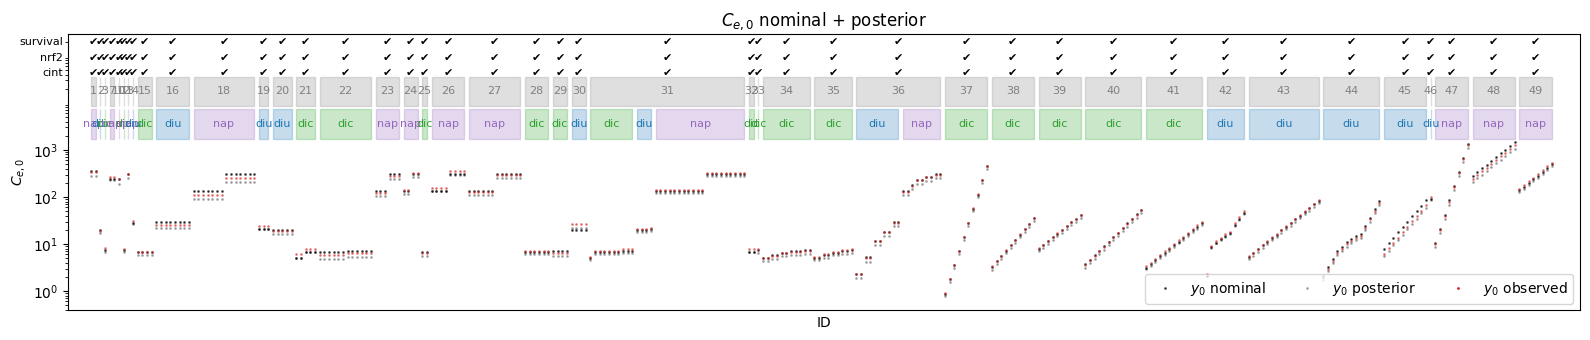

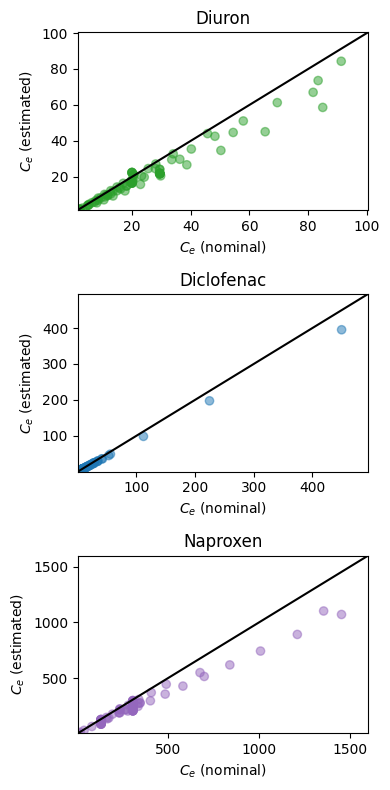

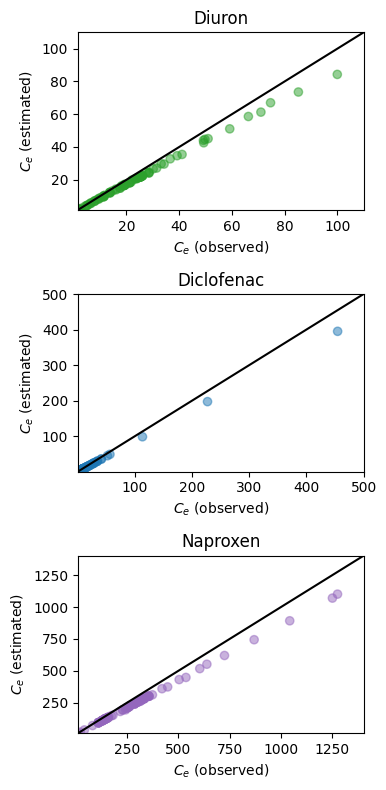

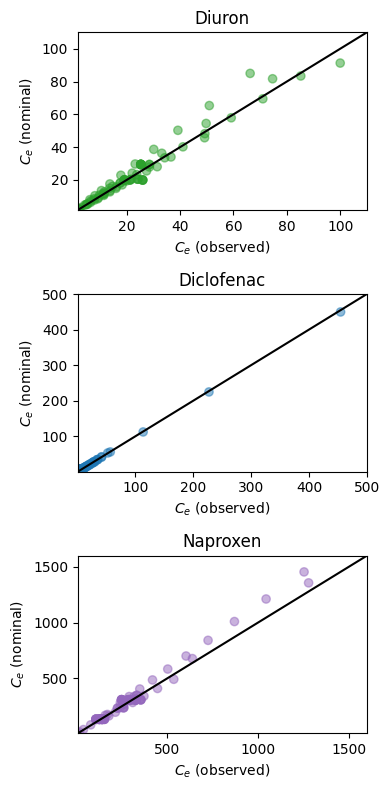

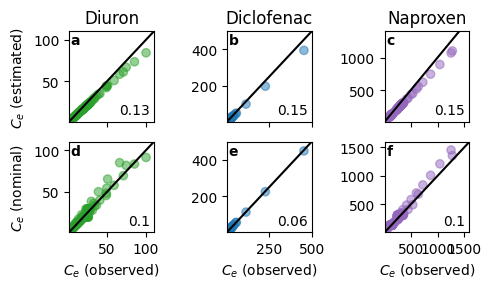

In [ ]:
sim = setup_simulation_study(experimental_variability=0.1, within_experiment_endpoint_overlap=0.5)

sim = run_inference(sim)
rel_bias, abs_bias = compute_bias(sim)

print(rel_bias)